In [1]:
!python -V

Python 3.8.10


In [2]:
import pandas as pd

In [3]:
import math

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


**Q1. Downloading the data**

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records"

Download the data for January and February 2021

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

**Answer 1:**

In [8]:
len(df) #answer_1

1154112

**Q2. Computing duration**

**Answer 2:**

In [9]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.mean()

19.167224093791006

Data Preparation

Check the distribution of the duration variable. There are some outliners.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [10]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

rec_start = len(df)
print(rec_start)

df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

rec_finish = len(df)
print(rec_finish)

1154112
1109826


How many records did you drop?

In [11]:
rec_dropped = rec_start - rec_finish
rec_dropped #How many records did you drop?

44286

**Q3. Missing values**

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1"

What's the fractions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

In [12]:
df.PUlocationID.isna().value_counts()

True     927008
False    182818
Name: PUlocationID, dtype: int64

In [13]:
df.PUlocationID.isna().value_counts()

True     927008
False    182818
Name: PUlocationID, dtype: int64

In [14]:
df.PUlocationID.isnull().sum()

927008

**Answer 3:**

In [15]:
answer_3  = (df.PUlocationID.isnull().sum()/len(df.PUlocationID))*100
math.floor(answer_3)

83

Let's replace them with "-1"

In [16]:
df.DOlocationID.isna().value_counts()

False    961919
True     147907
Name: DOlocationID, dtype: int64

In [17]:
df.PUlocationID.fillna(-1)

0           -1.0
1           -1.0
3           -1.0
4           -1.0
5           -1.0
           ...  
1154107      7.0
1154108     44.0
1154109    171.0
1154110     15.0
1154111     -1.0
Name: PUlocationID, Length: 1109826, dtype: float64

In [18]:
df.DOlocationID.fillna(-1)

0           -1.0
1           -1.0
3           72.0
4           61.0
5           71.0
           ...  
1154107      7.0
1154108     91.0
1154109    171.0
1154110     15.0
1154111     -1.0
Name: DOlocationID, Length: 1109826, dtype: float64

**Q4. One-hot encoding**

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.  

- Turn the dataframe into a list of dictionaries  
- Fit a dictionary vectorizer  
- Get a feature matrix from it  

What's the dimensionality of this matrix? (The number of columns)

In [19]:
categorical = ['PUlocationID', 'DOlocationID']
# numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [20]:
# train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

In [21]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

**Answer 4:**

In [22]:
X_train.shape[1]

525

**Q5. Training a model**

Now let's use the feature matrix from the previous step to train a model.  

- Train a plain linear regression model with default parameters  
- Calculate the RMSE of the model on the training data  

What's the RMSE on train?

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

**Answer 5:**

In [24]:
mean_squared_error(y_train, y_pred, squared=False)

10.52851910720539

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


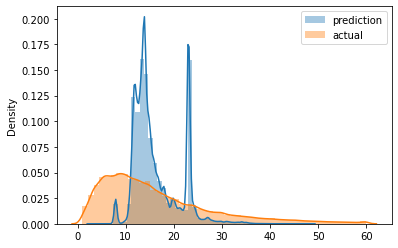

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [26]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    #df.PUlocationID.fillna(-1)
    #df.DOlocationID.fillna(-1)

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [28]:
df_train.PUlocationID.fillna(-1)
df_train.DOlocationID.fillna(-1)

0            nan
1            nan
3           72.0
4           61.0
5           71.0
           ...  
1154107      7.0
1154108     91.0
1154109    171.0
1154110     15.0
1154111      nan
Name: DOlocationID, Length: 1109826, dtype: object

In [29]:
len(df_train), len(df_val)

(1109826, 990113)

In [12]:
#df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
#df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
#categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
#numerical = ['trip_distance']

#dv = DictVectorizer()

#train_dicts = df_train[categorical + numerical].to_dict(orient='records')
#X_train = dv.fit_transform(train_dicts)

#val_dicts = df_val[categorical + numerical].to_dict(orient='records')
#X_val = dv.transform(val_dicts)

In [30]:
categorical = ['PUlocationID', 'DOlocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.014283150723951

In [33]:
mean_squared_error(y_val, y_pred, squared=False)

11.014283150723951

In [34]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [35]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.303108310943548

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [38]:
mean_squared_error(y_train, y_pred, squared=False)

10.52851910720539

In [39]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.014283150723951

**Answer 6:**

Answer is **11.01** and I **choose** the nearest value **12.85** in the list of responses!